In [1]:
import pandas as pd
import numpy as np
import json
from IPython.display import JSON

In [62]:
data = pd.read_csv('chicago-food-inspections/food-inspections.csv')

#### Preprocess the data

We only consider the columns which we use to match with Yelp. By removing duplicates, we get an approximative list of all unique businesses. 

In [92]:
establishments = data[['DBA Name', 'AKA Name', 'Address', 'City', 'State']].copy().drop_duplicates().reset_index()
# All Addresses exist, but we may need to examine the cities and state to complete
establishments.isnull().any()

index       False
DBA Name    False
AKA Name     True
Address     False
City         True
State        True
dtype: bool

In [93]:
# Add two columns to relate to Yelp data
establishments['id'] = None

# The matches column will be positive if we have already queried the API for this row
establishments['matches'] = -1

# We set the value to -1 if some of the data is missing. This will allow us to more carefully get the data.
establishments.loc[establishments['City'].isnull(), 'matches'] = -2
establishments.loc[establishments['City'].isnull(), 'matches'] = -2

In [97]:
establishments.nunique()

index       32373
DBA Name    27476
AKA Name    26210
Address     18035
City           71
State           4
id              0
matches         2
dtype: int64

### Yelp Database

Connect to the Yelp API but keep the key in local environment and away from TAs wanting to use my account.

In [5]:
import os
from yelpapi import YelpAPI

YELP_API_KEY = os.environ['YELP_API_KEY']
YELP_CLIENT_ID = os.environ['YELP_CLIENT_ID']
client = YelpAPI(YELP_API_KEY)

##### Read already acquired data

In [2]:
# The yelp_df is a selection of columns of the original df, containing only location information
# We then drop all duplicates and reset the index in order to more easily cross reference with the new data
# We also include a id col corresponding to the yelp id, and a count of how many results returned
yelp_df = pd.read_pickle('yelp/yelp.pkl')

# Contains the scrapped data from yelp
scrapped = pd.read_pickle('yelp/scrapped.pkl')

# Contains remaining data such as reviews, review count, price, and food categories
business = pd.read_pickle('yelp/business.pkl')

# For each business, we get 3 reviews with the start of the text and a rating 
reviews = pd.read_pickle('yelp/reviews.pkl')

##### Functions to get data from Yelp

#### Match establishments to Yelp and get ID along with address information

In [3]:
"""
Apply transformation to a business query which will fit the format of our scrapping dataframe.
"""
def business_match_to_df_row(business_):
    business = business_.copy()
    business.update(business.pop('coordinates'))
    business.update(business.pop('location'))
    business.pop('phone')
    business.pop('display_phone')
    business.pop('country')
    if str(business['address2']) == '' or not business['address2']:
        del business['address2']
    if str(business['address3']) == '' or not business['address3']:
        business.pop('address3', None)
    return business

In [585]:
for i in range(0,len(yelp_df)):
    # Get the i-th row of the data frame
    row = yelp_df.iloc[i]

    # Special case when our search terms contain NaN
    if row['matches'] == -2:
        continue

    # We haven't requested the data yet and no NaN im the request
    if row['matches'] == -1:
        # Some rows have only DBA / AKA
        row_name = row['DBA Name'] if row[['AKA Name']].isnull().values.any() else row['AKA Name']

        # Name too long
        if row_name == "MAE'S EARLY CHILDHOOD DEVELOPMENT AND THERAPEUTIC DAY CARE CENTER, INCORPORATED":
            continue
        query = client.business_match_query(name=row_name,
                                            city=row['City'],
                                            state=row['State'],
                                            country='US',
                                            address1=row['Address'])

        # We note how many matches we got and only take the first one
        yelp_df.loc[yelp_df.index[i], 'matches'] = len(query['businesses'])

        yelp_df.loc[yelp_df.index[i], 'id'] = query['businesses'][0]['id']
        scrapped = scrapped.append(pd.DataFrame([business_match_to_df_row(query['businesses'][0])]))
        continue

In [750]:
print('Total unique Yelp establishments :', yelp_df[yelp_df['matches'] > 0]['id'].nunique())
print('Total matches : ', len(yelp_df[yelp_df['matches'] > 0]))
print('Total establishments :', len(yelp_df))
print('Total unique matches :', scrapped['id'].nunique())
print('Ratio matched :', scrapped['id'].nunique()/len(yelp_df[yelp_df['matches'] >= 0]))

Total unique Yelp establishments : 14497
Total matches :  17743
Total establishments : 32374
Total unique matches : 12100
Ratio matched : 0.37383755059165197


##### Get more information for each business

In [588]:
business[business['is_closed'].isna()]

,id,is_closed,review_count,categories,rating,price,transactions
6190,p6mixTjSjKGcy_2AaBKzgQ,NaN,NaN,NaN,NaN,NaN,NaN
6192,YrOyHe-VdN-YENnm_-moHw,NaN,NaN,NaN,NaN,NaN,NaN
6193,aqS1qE9LnceDVoVMY77fBw,NaN,NaN,NaN,NaN,NaN,NaN
10231,rGYpTg_FKgfsrQDGvIdmlg,NaN,NaN,NaN,NaN,NaN,NaN
10448,N7FBGIQNFeK_JGCW5UkXaQ,NaN,NaN,NaN,NaN,NaN,NaN


In [589]:
# Get all other information from business
wanted_business = ['id','is_closed','review_count','categories','rating','price','transactions']
for i in range(0,len(scrapped)):
    row = scrapped.iloc[i]
    if not business['id'].isin([row['id']]).any():
        try:
            query = client.business_query(id=row['id'])
        except YelpAPI.YelpAPIError as e:
            business = business.append({'id':row['id']}, ignore_index=True)
        else:
            result = dict((k, query[k]) for k in wanted_business if k in query)
            business = business.append([result])

In [580]:
yelp_df[yelp_df['id'] == 'AvXFEa1RmfCrgVx7CQFOpA']

,index,DBA Name,AKA Name,Address,City,State,id,matches
5951,8892,FOREST VIEW BAKERY,FOREST VIEW BAKERY,6454 N MILWAUKEE AVE,CHICAGO,IL,AvXFEa1RmfCrgVx7CQFOpA,1
32353,194489,FOREST VIEW DELI,FOREST VIEW DELI,6452 N MILWAUKEE AVE,CHICAGO,IL,AvXFEa1RmfCrgVx7CQFOpA,1


In [579]:
scrapped[scrapped.id == 'xWCqqPhcuDZu-KYtGksc0g']

,address1,address2,address3,alias,city,display_address,id,latitude,longitude,name,state,zip_code
0,4660 W Irving Park Rd,NaN,NaN,jewel-osco-chicago-75,Chicago,"[4660 W Irving Park Rd, Chicago, IL 60641]",xWCqqPhcuDZu-KYtGksc0g,41.955455,-87.744896,Jewel-Osco,IL,60641
0,4660 W Irving Park Rd,NaN,NaN,jewel-osco-chicago-75,Chicago,"[4660 W Irving Park Rd, Chicago, IL 60641]",xWCqqPhcuDZu-KYtGksc0g,41.955455,-87.744896,Jewel-Osco,IL,60641


##### Get reviews

In [597]:
wanted_reviews = ['id','text','rating','time_created']
for i in range(0,1000):
    row = scrapped.iloc[i]
    if not reviews['id'].isin([row['id']]).any():
        query = client.reviews_query(id=row['id'])
        for review in query['reviews']:
            result = dict((k, review[k]) for k in wanted_reviews if k in review)
            result.update({'business_id':row['id']})
            reviews = reviews.append([result])

YelpAPIError: BUSINESS_UNAVAILABLE: We may not be able to provide details for certain businesses, for example if they do not have any reviews yet.

##### Save the all data

In [700]:
yelp_df.to_pickle('yelp/yelp.pkl')
scrapped.to_pickle('yelp/scrapped.pkl')
business.to_pickle('yelp/business.pkl')
reviews.to_pickle('yelp/reviews.pkl')

In [74]:
data = pd.read_pickle('clean.pkl')

## Yelp Data Analysis

In [671]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error,r2_score, roc_auc_score, roc_curve
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import statsmodels.api as sm
import random
import numpy as np
from matplotlib import pyplot

#### Clean the data

We must first recombine the results from Yelp with the original database. 

We will only consider establishments individually and get some aggregates of all their inspections.

Because we are looking at Yelp reviews as of December 2019, it would we should make sure that we only take recent inspections.

We only look at canvass type inspections as restaurant owners are not aware they will be inspected, and this it will probide a more accurate view of the 

In [1162]:
pd.set_option('display.max_columns', None)

# Add column name like the clean BD
tmp_df = yelp_df.copy()
tmp_df['Name'] = tmp_df['AKA Name'].fillna(tmp_df['DBA Name'])

clean_data = pd.read_pickle('data/data.pkl')
clean_data = clean_data.merge(right=tmp_df[['Name', 'Address','id']], how='inner', left_on=['Name', 'Address'],right_on=['Name', 'Address'])

# Remove the ones without ID
clean_data = clean_data[~clean_data['id'].isna()]
clean_data = clean_data.merge(right=scrapped, how='inner', on='id')
clean_data = clean_data.merge(right=business[~business['review_count'].isna()], how='inner', on='id')

# Set the column types correctly 
clean_data['is_closed'] = clean_data['is_closed'].apply(lambda x: False if x < 1 else True).astype('category')
clean_data['datetime'] = pd.to_datetime(clean_data[['year', 'month', 'day']])
clean_data['review_count'] = clean_data['review_count'].astype('int64')
clean_data['Risk'] = clean_data['Risk'].astype('category')
clean_data['Facility Type'] = clean_data['Facility Type'].astype('category')
clean_data['state'] = clean_data['state'].astype('category')
clean_data['price'] = clean_data['price'].fillna('').apply(lambda x: len(x))


# Remove some things
clean_data = clean_data[clean_data['Results'] != 'No Entry']
clean_data = clean_data[clean_data['datetime'] > pd.Timestamp(2019,1,1)]
clean_data = clean_data[clean_data['Inspection Type'] == 'canvass']

# Get latest result and risk level
latest = clean_data[~clean_data['Results'].isin(['Out of Business','Not Ready', 'Business Not Located'])]
latest = latest.loc[latest.groupby('id')['datetime'].idxmax()][['id','Risk','Results']]
latest.columns = ['id', 'last_risk', 'last_result']
latest['last_risk'] = latest['last_risk'].astype('category')
latest['last_result'] = latest['last_result'].astype('category')

# Create table with pass status for each ID
pass_status = clean_data.groupby(['id','Results']).size().unstack(1).fillna(0).astype('int64')
pass_status['pass_fail_ratio'] = (pass_status['Pass w/ Conditions'] + pass_status['Pass'])/(pass_status['Fail'] + pass_status['Pass w/ Conditions'] + pass_status['Pass'])
pass_status['result_max'] = pass_status.idxmax(axis=1) 

clean_data = clean_data.merge(right=latest, how='inner', on='id')
clean_data = clean_data.merge(right=pass_status, how='inner', on='id')

# Interestingly there are business that have been reevaluated after being checked OOB
clean_data = clean_data[(clean_data['Out of Business'] == 0)]
clean_data = clean_data[~clean_data['last_result'].isin(['Out of Business','Not Ready', 'Business Not Located'])]
clean_data['last_result'] = clean_data['last_result'].cat.remove_unused_categories()

#### Comparing means

We only take the rating, price category, latest inspection result, number of results, then plot a histogram of ratings.

2: full pass 
1: passed with conditions 
0: fail
1    2105
0     789
2     474
Name: pass, dtype: int64


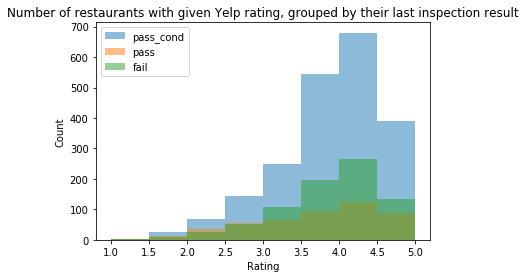

In [1173]:
features = [ 'id', 'rating','price', 'last_result', 'review_count']

X = clean_data[features].drop_duplicates().set_index('id')
X = X[(X.review_count > 4)]
X = pd.get_dummies(X, drop_first=True)
X['pass'] = 2*X['last_result_Pass'] + X['last_result_Pass w/ Conditions']
X = X.drop(columns=['last_result_Pass','last_result_Pass w/ Conditions', 'review_count'])
X['price'] = X['price'].apply(lambda x: np.ceil(x/2))
print("2: full pass \n1: passed with conditions \n0: fail")
print(X['pass'].value_counts())

bins = np.arange(1, 5 + .5, .5)
pyplot.hist(X[X['pass'] == 1]['rating'], bins=bins, alpha=0.5, label='pass_cond')
pyplot.hist(X[X['pass'] == 2]['rating'], bins=bins, alpha=0.5, label='pass')
pyplot.hist(X[X['pass'] == 0]['rating'], bins=bins, alpha=0.5, label='fail')
pyplot.legend(loc='upper left')
pyplot.title("Number of restaurants with given Yelp rating, grouped by their last inspection result")
pyplot.xlabel("Rating")
pyplot.ylabel("Count")
pyplot.show()

After grouping the results by their price category (no data, \\$ 0 - \\$ 30, \\$ 30 +), we look at the mean score for establishments that passed, passed conditionnaly or failed.

In [1114]:
X.groupby(['price','pass'])['rating'].agg(['mean','count'])

mean  count
price pass                 
0.0   0     3.725275     91
      1     3.897619    210
      2     3.670213     94
1.0   0     3.636905    672
      1     3.615874   1808
      2     3.400552    362
2.0   0     3.519231     26
      1     3.913793     87
      2     4.138889     18

For each category, we look at the mean of restaurants that failed, compared to those that passed, and their difference.

In [1119]:
X.groupby(['price']).apply(lambda x: [x[x['pass'] == 0]['rating'].mean(),
                                      x[x['pass'] > 0 ]['rating'].mean(),
                                      x[x['pass'] > 0]['rating'].mean() - x[x['pass'] == 0 ]['rating'].mean()])

price
0.0    [3.7252747252747254, 3.8273026315789473, 0.102...
1.0    [3.636904761904762, 3.579953917050691, -0.0569...
2.0    [3.519230769230769, 3.9523809523809526, 0.4331...
dtype: object

Results of a t-test for each price category. Only the \\$ 30 + category is significant.

In [1120]:
X.groupby(['price']).apply(lambda x: stats.ttest_ind(x[x['pass'] == 0]['rating'],x[x['pass'] > 0 ]['rating']))

price
0.0     (-0.9278389008292174, 0.35406062236637204)
1.0      (1.8283968629916107, 0.06759484903682784)
2.0    (-3.486125407768093, 0.0006703877124443016)
dtype: object

### Logistic Classification



We apply the same transformation, combining the pass_cond and pass rating, and taking a random sample of equal size for both categories.

In [1174]:
features = [ 'id', 'rating','price', 'last_result', 'review_count']

X = clean_data[features].drop_duplicates().set_index('id')
X = X[(X.review_count > 4)]# & (X['price'] > 0) & (X['price'] < 4)]
X = pd.get_dummies(X, drop_first=True)
X['pass'] = 1*X['last_result_Pass'] + X['last_result_Pass w/ Conditions']
X = X.drop(columns=['last_result_Pass','last_result_Pass w/ Conditions', 'review_count'])
X['price'] = X['price'].apply(lambda x: np.ceil(x/2))

X_fail = X[X['pass'] == 0]
X_pass = X[X['pass'] > 0]
X_pass = X_pass.sample(n=X_fail.shape[0], random_state=0)
X = X_fail.append(X_pass)
print(X['pass'].value_counts())

x_train, x_test, y_train, y_test = train_test_split(X.drop(columns=['pass']), X['pass'], test_size=0.25, random_state=42)

1    789
0    789
Name: pass, dtype: int64


We now try to fit a logistic model to determine a probability that a restaurant passes the inspection given its rating.
This is however not very significant.

In [1175]:
logit_model = sm.Logit(y_train,x_train)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.781289
         Iterations 3
                         Results: Logit
Model:              Logit            Pseudo R-squared: inf      
Dependent Variable: pass             AIC:              1852.5298
Date:               2019-12-19 19:34 BIC:              1862.6814
No. Observations:   1183             Log-Likelihood:   -924.26  
Df Model:           1                LL-Null:          0.0000   
Df Residuals:       1181             LLR p-value:      1.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     3.0000                                      
------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025   0.975]
------------------------------------------------------------------
rating     0.0250     0.0367    0.6804   0.4963   -0.0469   0.0969
price     -0.0729     0.1382   -0.5271   0.5981   -0.3438   0.1981



/usr/local/anaconda3/envs/ada/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/ada/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/anaconda3/envs/ada/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:3390: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


In [1176]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(x_test, y_test)))

cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred))

Accuracy of logistic regression classifier on test set: 0.48
[[ 45 159]
 [ 47 144]]
              precision    recall  f1-score   support

           0       0.49      0.22      0.30       204
           1       0.48      0.75      0.58       191

    accuracy                           0.48       395
   macro avg       0.48      0.49      0.44       395
weighted avg       0.48      0.48      0.44       395



/usr/local/anaconda3/envs/ada/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


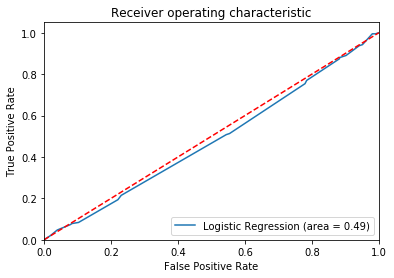

In [1177]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Linear Model

We try to use a linear model but this is not very useful for our use case. We leave still leave it here.

In [1158]:
# Create linear regression object
regr = LinearRegression()

# Train the model using the training sets
regr.fit(x_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(x_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

Coefficients: 
 [ 0.01041576 -0.01371361]
Mean squared error: 0.25
Coefficient of determination: -0.00


In [1157]:
results = sm.OLS(y_train, x_train).fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                   pass   R-squared (uncentered):                  -2.530
Model:                            OLS   Adj. R-squared (uncentered):             -2.536
Method:                 Least Squares   F-statistic:                             -423.2
Date:                Thu, 19 Dec 2019   Prob (F-statistic):                        1.00
Time:                        18:36:58   Log-Likelihood:                         -874.13
No. Observations:                1183   AIC:                                      1752.
Df Residuals:                    1181   BIC:                                      1762.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------